In [ ]:
import tensorflow as tf
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_file_from_path(path):
    return np.array([str(f) for f in list(path.iterdir())])

In [ ]:
def load_image_and_resize(image_file, target_size=None):
  # load and decode image as jpeg
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image, channels=3)

  if target_size is not None:
    if (image.shape[0] != target_size[0] or
        image.shape[1] != target_size[1]):
        image = tf.image.resize(image, target_size)

  image = tf.cast(image, tf.float32)
  return image

In [ ]:
def random_flip(image, p=0.5):
  if tf.random.uniform(()) > p:
      image = tf.image.flip_left_right(image)

  return image

In [ ]:
def normalize(image):
  image = (image - 127.5) / 127.5

  return image

In [ ]:
def load_image(image_file):
  image = load_image_and_resize(image_file, (256, 256))
  image = random_flip(image)
  image = normalize(image)
  return image

In [ ]:
def create_image_dataset(image_file_paths,
                         suffle_buffer_size=10,
                         map_func=None):
    ds = tf.data.Dataset.from_tensor_slices(image_file_paths)
    ds = ds.shuffle(suffle_buffer_size)
    if map_func is not None:
        ds = ds.map(map_func, tf.data.AUTOTUNE)
    ds = ds.cache()

    return ds

In [ ]:
dataset_root_path = "/content/drive/MyDrive/CycleGAN_model/dataset/vangogh2photo"

# get all subfolders that contain images
train_a_path = pathlib.Path(os.path.join(dataset_root_path, "trainA"))
train_b_path = pathlib.Path(os.path.join(dataset_root_path, "trainB"))
test_a_path = pathlib.Path(os.path.join(dataset_root_path, "testA"))
test_b_path = pathlib.Path(os.path.join(dataset_root_path, "testB"))

# get all file paths
train_a = get_file_from_path(train_a_path)
print(f"train A: {len(train_a)} files")
train_b = get_file_from_path(train_b_path)
print(f"train B: {len(train_b)} files")
test_a = get_file_from_path(test_a_path)
print(f"test A: {len(test_a)} files")
test_b = get_file_from_path(test_b_path)
print(f"test A: {len(test_b)} files")

# create tensorflow image datasets
train_a_ds = create_image_dataset(train_a, len(train_a), load_image)
train_a_ds = train_a_ds.batch(1).prefetch(tf.data.AUTOTUNE)

train_b_ds = create_image_dataset(train_b, len(train_b), load_image)
train_b_ds = train_b_ds.batch(1).prefetch(tf.data.AUTOTUNE)

test_a_ds = create_image_dataset(test_a, len(test_a), load_image)
test_b_ds = create_image_dataset(test_b, len(test_b), load_image)

# create unpaired training dataset A & B
train_ds = tf.data.Dataset.zip((train_a_ds, train_b_ds))

train A: 874 files
train B: 1500 files
test A: 874 files
test A: 1038 files


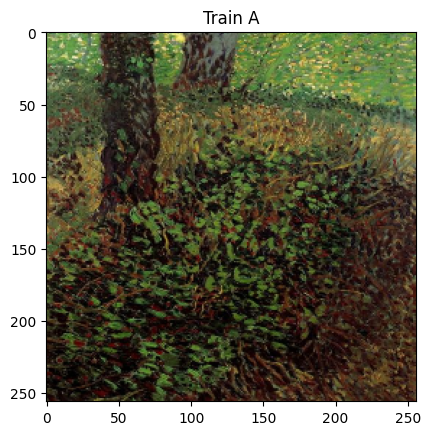

In [ ]:
for img in train_a_ds.unbatch().take(1):
  plt.imshow((img+1)/2)
  plt.title("Train A")
  plt.show()

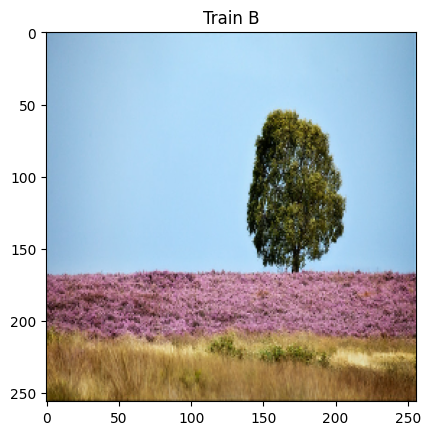

In [ ]:
for img in train_b_ds.unbatch().take(1):
  plt.imshow((img+1)/2)
  plt.title("Train B")
  plt.show()

In [ ]:
# tf.keras.saving.get_custom_objects().clear()
#
@tf.keras.utils.register_keras_serializable(package='CycleGAN')
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

  def get_config(self):
    return {"epsilon": self.epsilon}

  @classmethod
  def from_config(cls, config):
    return cls(**config)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from tabulate import tabulate
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, Conv2DTranspose
from keras.layers import LeakyReLU, ReLU, Concatenate, ZeroPadding2D, Dropout
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy

class CycleCGAN():
  def __init__(self, out_image_channels=3, gen_conv=True, disc_conv=True):
    super().__init__()

    self.out_image_channels = out_image_channels
    self.image_shape = (256, 256, 3)
    self.LAMBDA = 10

    self.lr_scheduler = ExponentialDecay(initial_learning_rate=0.0002,
                                         decay_steps=50,
                                         decay_rate=0.1,
                                         staircase=True)

    # Optimizer
    self.dx_optimizer = Adam(0.0002, 0.5)
    self.dy_optimizer = Adam(0.0002, 0.5)
    self.gen_g_optimizer = Adam(0.0002, 0.5)
    self.gen_f_optimizer = Adam(0.0002, 0.5)

    # Create discriminator
    self.discriminator_x = self.build_discriminator(norm_type='instancenorm', conv=disc_conv)
    self.discriminator_y = self.build_discriminator(norm_type='instancenorm', conv=disc_conv)

    # Create generator
    self.generator_g = self.build_generator(conv=gen_conv)
    self.generator_f = self.build_generator(conv=gen_conv)

  def down_sample_block(self, filters, kernel_size, norm_type="instancenorm",
                        conv2d_type="conv", conv2d_depth_multiplier=2,
                        apply_norm=True):
    init_weights = tf.random_normal_initializer(0., 0.02)

    block = Sequential()

    if conv2d_type == "conv":
        block.add(Conv2D(filters, kernel_size, strides=2, padding="same",
                         use_bias=False, kernel_initializer=init_weights))
    elif conv2d_type == "depthwise":
        block.add(DepthwiseConv2D(depth_multiplier=conv2d_depth_multiplier,
                                  kernel_size=kernel_size,
                                  strides=2,
                                  padding="same",
                                  use_bias=False,
                                  depthwise_initializer=init_weights))
    else:
        raise ValueError("Invalid value of conv2d_type either conv or depthwise")

    if apply_norm:
      if norm_type.lower() == "batchnorm":
        block.add(BatchNormalization())
      elif norm_type.lower() == "instancenorm":
        block.add(InstanceNormalization())

    block.add(LeakyReLU())

    return block

  def up_sample_block(self, filters, kernel_size, norm_type="instancenorm",
                      apply_dropout=False, dropout_rate=0.5):
    init_weights = tf.random_normal_initializer(0., 0.02)

    block = Sequential()

    block.add(Conv2DTranspose(filters, kernel_size, strides=2, padding="same",
                              use_bias=False, kernel_initializer=init_weights))

    if norm_type.lower() == "batchnorm":
      block.add(BatchNormalization())
    elif norm_type.lower() == "instancenorm":
      block.add(InstanceNormalization())

    if apply_dropout:
      block.add(Dropout(dropout_rate))

    block.add(ReLU())

    return block

  def build_discriminator(self, norm_type="instancenorm", conv=True):
    init_weights = tf.random_normal_initializer(0., 0.02)

    inputs = Input(shape=self.image_shape, name="input_image")
    x = inputs

    if conv:
        x = self.down_sample_block(64, 4, apply_norm=False)(x) # 128
        x = self.down_sample_block(128, 4)(x) # 64
        x = self.down_sample_block(256, 4)(x) # 32
    else:
        x = self.down_sample_block(64, 4, apply_norm=False, conv2d_type="depthwise")(x) # 128
        x = self.down_sample_block(128, 4, conv2d_type="depthwise")(x) # 64
        x = self.down_sample_block(256, 4, conv2d_type="depthwise")(x) # 32

    x = ZeroPadding2D()(x) # 34

    if conv:
        x = Conv2D(512, 4, 1, kernel_initializer=init_weights, use_bias=False)(x) # 31
    else:
        x = DepthwiseConv2D(depth_multiplier=1,
                              kernel_size=4,
                              strides=1,
                              use_bias=False,
                              depthwise_initializer=init_weights)(x)

    if norm_type.lower() == "batchnorm":
      x = BatchNormalization()(x)
    elif norm_type.lower() == "instancenorm":
      x = InstanceNormalization()(x)

    x = LeakyReLU()(x)

    x = ZeroPadding2D()(x) # 33

    if conv:
        outputs = Conv2D(1, 4, 1, kernel_initializer=init_weights)(x) # 30
    else:
        outputs = DepthwiseConv2D(depth_multiplier=1,
                                  kernel_size=4,
                                  strides=1,
                                  depthwise_initializer=init_weights)(x)

    return Model(inputs, outputs)

  def build_generator(self, conv=True):
    init_weights = tf.random_normal_initializer(0., 0.02)

    inputs = Input(shape=self.image_shape, name="input")

    if conv:
        down_samples = [
            self.down_sample_block(64, 4, apply_norm=False),#128
            self.down_sample_block(128, 4),#64
            self.down_sample_block(256, 4),#32
            self.down_sample_block(512, 4),#16
            self.down_sample_block(512, 4),#8
            self.down_sample_block(512, 4),#4
            self.down_sample_block(512, 4),#2
            self.down_sample_block(512, 4)#1
        ]
    else:
        down_samples = [
            self.down_sample_block(64, 4, apply_norm=False, conv2d_type="depthwise"),#128
            self.down_sample_block(128, 4, conv2d_type="depthwise"),#64
            self.down_sample_block(256, 4, conv2d_type="depthwise"),#32
            self.down_sample_block(512, 4, conv2d_type="depthwise"),#16
            self.down_sample_block(512, 4, conv2d_type="depthwise"),#8
            self.down_sample_block(512, 4, conv2d_type="depthwise"),#4
            self.down_sample_block(512, 4, conv2d_type="depthwise"),#2
            self.down_sample_block(512, 4, conv2d_type="depthwise")#1
        ]

    up_samples = [
            self.up_sample_block(512, 4, apply_dropout=True),#2
            self.up_sample_block(512, 4, apply_dropout=True),#4
            self.up_sample_block(512, 4, apply_dropout=True),#8
            self.up_sample_block(512, 4),#16
            self.up_sample_block(256, 4),#32
            self.up_sample_block(128, 4),#64
            self.up_sample_block(64, 4)#128
    ]

    #256
    last = Conv2DTranspose(self.out_image_channels, 4, strides=2,
                           padding="same", kernel_initializer=init_weights,
                           activation="tanh", name="output")

    x = inputs
    skips = []
    for down in down_samples:
      x = down(x)
      skips.append(x)

    skips = skips[:-1][::-1]

    for up, skip in zip(up_samples, skips):
      x = up(x)
      x = Concatenate()([x, skip])

    outputs = last(x)

    return Model(inputs, outputs)

  def discriminator_loss(self, real, generated):
    obj_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                  reduction=tf.keras.losses.Reduction.NONE)
    real_loss = obj_loss(tf.ones_like(real), real)
    gen_loss = obj_loss(tf.zeros_like(generated), generated)
    total_loss = (real_loss + gen_loss) * 0.5

    return total_loss

  def generator_loss(self, generated):
    obj_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                  reduction=tf.keras.losses.Reduction.NONE)
    gen_loss = obj_loss(tf.ones_like(generated), generated)

    return gen_loss

  def calculate_cycle_loss(self, real_images, cycle_images):
    c_loss = tf.reduce_mean(tf.abs(real_images - cycle_images))

    return self.LAMBDA * c_loss

  def identity_loss(self, real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return self.LAMBDA * 0.5 * loss

  def train_step(self, real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
      # Generator G X(real) -> Y(fake)
      # Generator F Y -> X
      fake_y = self.generator_g(real_x, training=True)
      cycle_x = self.generator_f(fake_y, training=True)

      # Generator F Y(real) -> X(fake)
      # Generator G X -> Y
      fake_x = self.generator_f(real_y, training=True)
      cycle_y = self.generator_g(fake_x, training=True)

      # generate identity
      same_y = self.generator_g(real_y, training=True)
      same_x = self.generator_f(real_x, training=True)

      # discriminator for real
      disc_real_x = self.discriminator_x(real_x, training=True)
      disc_real_y = self.discriminator_y(real_y, training=True)

      # discriminator for fake
      disc_fake_x = self.discriminator_x(fake_x, training=True)
      disc_fake_y = self.discriminator_y(fake_y, training=True)

      # generator loss
      gen_g_loss = self.generator_loss(disc_fake_y)
      gen_f_loss = self.generator_loss(disc_fake_x)

      # calcualte total cycle
      cycle_real_x = self.calculate_cycle_loss(real_x, cycle_x)
      cycle_real_y = self.calculate_cycle_loss(real_y, cycle_y)
      total_cycle_loss = cycle_real_x + cycle_real_y

      # Total generator loss = adversarial loss + cycle loss
      total_gen_g_loss = gen_g_loss + total_cycle_loss + self.identity_loss(real_y, same_y)
      total_gen_f_loss = gen_f_loss + total_cycle_loss + self.identity_loss(real_x, same_x)

      # disciminator loss
      disc_x_loss = self.discriminator_loss(disc_real_x, disc_fake_x)
      disc_y_loss = self.discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate both generator and discriminator's gradients
    gen_g_grads = tape.gradient(total_gen_g_loss, self.generator_g.trainable_variables)
    gen_f_grads = tape.gradient(total_gen_f_loss, self.generator_f.trainable_variables)

    disc_x_grads = tape.gradient(disc_x_loss, self.discriminator_x.trainable_variables)
    disc_y_grads = tape.gradient(disc_y_loss, self.discriminator_y.trainable_variables)

    # Optimize generator and discriminator's training variables with
    # gradients
    self.gen_g_optimizer.apply_gradients(zip(gen_g_grads, self.generator_g.trainable_variables))
    self.gen_f_optimizer.apply_gradients(zip(gen_f_grads, self.generator_f.trainable_variables))

    self.dx_optimizer.apply_gradients(zip(disc_x_grads, self.discriminator_x.trainable_variables))
    self.dy_optimizer.apply_gradients(zip(disc_y_grads, self.discriminator_y.trainable_variables))

    return {
        "gen_g_loss": total_gen_g_loss,
        "gen_f_loss": total_gen_f_loss,
        "disc_x_loss": disc_x_loss,
        "disc_y_loss": disc_y_loss
    }

  def train(self, dataset, epochs, batch_size=32, sampling_image_g_func=None,
            sampling_image_f_func=None, sampling_interval=10):
    if not isinstance(dataset, (tf.data.Dataset)):
      raise Exception("dataset must be tf.data.Dataset with unpair data x and y")

    # Iterate epochs
    for epoch in range(epochs):
      gen_g_loss = []
      gen_f_loss = []
      disc_x_loss = []
      disc_y_loss = []

      # update optimizer's learning rate
      self.gen_f_optimizer.learning_rate = self.lr_scheduler(epoch)
      self.gen_g_optimizer.learning_rate = self.lr_scheduler(epoch)

      print(f"gen_f learning rate: {self.gen_f_optimizer.learning_rate.numpy()}")
      print(f"gen_g learning rate: {self.gen_g_optimizer.learning_rate.numpy()}")

      # Train on each mini batch dataset
      for x_batch, y_batch in tqdm(dataset, f"epoch:{epoch+1}/{epochs} "):
        metrics = self.train_step(x_batch, y_batch)

        gen_g_loss.append(tf.reduce_mean(metrics["gen_g_loss"]))
        gen_f_loss.append(tf.reduce_mean(metrics["gen_f_loss"]))
        disc_x_loss.append(tf.reduce_mean(metrics["disc_x_loss"]))
        disc_y_loss.append(tf.reduce_mean(metrics["disc_y_loss"]))

      gen_table = [
          ["gen_g_loss", "gen_f_loss"],
          [tf.reduce_mean(gen_g_loss).numpy(),
           tf.reduce_mean(gen_f_loss).numpy()]
      ]

      disc_table = [
          ["disc_x_loss", "disc_y_loss"],
          [tf.reduce_mean(disc_x_loss).numpy(),
           tf.reduce_mean(disc_y_loss).numpy()]
      ]

      print("Gnerator:")
      print(tabulate(gen_table, headers='firstrow', tablefmt='simple_grid'))
      print("Discriminator:")
      print(tabulate(disc_table, headers='firstrow', tablefmt='simple_grid'))

      # save generator model
      self.save_generator()

      # sampling image
      if (epoch+1) % sampling_interval == 0:
          if sampling_image_g_func is not None:
            sampling_image_g_func(self.generator_g, epoch)
          if sampling_image_f_func is not None:
            sampling_image_f_func(self.generator_f, epoch)

  def save_generator(self):
    print("Save model")
    self.generator_g.save("/content/drive/MyDrive/CycleGAN_model/model/gen_g_4.keras")
    self.generator_f.save("/content/drive/MyDrive/CycleGAN_model/model/gen_f_4.keras")
    self.generator_g.save("/content/drive/MyDrive/CycleGAN_model/model/gen_g_4.h5")
    self.generator_f.save("/content/drive/MyDrive/CycleGAN_model/model/gen_f_4.h5")

In [ ]:
def gen_images(test_dataset, file_path):
  if os.path.exists(file_path) == False:
    os.mkdir(file_path)

  def do_gen_image(gen_model, epoch):
    t_data = list(test_dataset.take(1).as_numpy_iterator())[0]

    input_image = t_data * 127.5 + 127.5
    input_image = tf.cast(input_image, tf.uint8)


    # make preidction
    input_data = tf.expand_dims(t_data, axis=0)
    out_image = gen_model(input_data, training=True)
    out_image = out_image * 127.5 +127.5
    out_image = tf.squeeze(out_image)
    out_image = tf.cast(out_image, tf.uint8)

    images = [input_image, out_image]
    titles = ["Input image", "Predict image"]

    r, c = 1, len(images)
    fig, axs = plt.subplots(r, c, squeeze=False)
    for i in range(r):
      for j in range(c):
        axs[i,j].imshow(images[j])
        axs[i,j].axis(False)
        axs[i,j].set_title(titles[j])
    fig.savefig("{}/epoch_{:05d}.png".format(file_path, epoch))

  return do_gen_image

In [ ]:
g = CycleCGAN(gen_conv=False, disc_conv=True)

In [ ]:
g.generator_f.summary()

Model: "functional_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_57             │ (None, 128, 128, 6)    │             96 │ input[0][0]            │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_58             │ (None, 64, 64, 12)     │            216 │ sequential_57[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_59             │ (None, 32, 32, 24)     │            432 │ sequential_58[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_60             │ (None, 16, 16, 48)     │            864 │ sequential_59[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_61             │ (None, 8, 8, 96)       │          1,728 │ sequential_60[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_62             │ (None, 4, 4, 192)      │          3,456 │ sequential_61[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_63             │ (None, 2, 2, 384)      │          6,912 │ sequential_62[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_64             │ (None, 1, 1, 768)      │         13,824 │ sequential_63[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_65             │ (None, 2, 2, 512)      │      6,292,480 │ sequential_64[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_21            │ (None, 2, 2, 896)      │              0 │ sequential_65[0][0],   │
│ (Concatenate)             │                        │                │ sequential_63[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_66             │ (None, 4, 4, 512)      │      7,341,056 │ concatenate_21[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_22            │ (None, 4, 4, 704)      │              0 │ sequential_66[0][0],   │
│ (Concatenate)             │                        │                │ sequential_62[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_67        

 Total params: 27,425,835 (104.62 MB)

 Trainable params: 27,425,835 (104.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
g.discriminator_x.summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_36 (Sequential)           │ (None, 128, 128, 64)        │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_37 (Sequential)           │ (None, 64, 64, 128)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_38 (Sequential)           │ (None, 32, 32, 256)         │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_4 (ZeroPadding2D)     │ (None, 34, 34, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 31, 31, 512)         │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ instance_normalization_36            │ (None, 31, 31, 512)         │           1,024 │
│ (InstanceNormalization)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_27 (LeakyReLU)           │ (None, 31, 31, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_5 (ZeroPadding2D)     │ (None, 33, 33, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 30, 30, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,765,569 (10.55 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
g.train(train_ds,
        20,
       sampling_image_g_func=gen_images(test_a_ds, "gen_g_images"),
       sampling_image_f_func=gen_images(test_b_ds, "gen_f_images"))

gen_f learning rate: 0.00019999999494757503
gen_g learning rate: 0.00019999999494757503


epoch:1/20 : 100%|██████████| 874/874 [29:42<00:00,  2.04s/it]


Gnerator:
┌──────────────┬──────────────┐
│   gen_g_loss │   gen_f_loss │
├──────────────┼──────────────┤
│      6.74188 │      7.07159 │
└──────────────┴──────────────┘
Discriminator:
┌───────────────┬───────────────┐
│   disc_x_loss │   disc_y_loss │
├───────────────┼───────────────┤
│      0.603791 │       0.64596 │
└───────────────┴───────────────┘
Save model


gen_f learning rate: 0.00019999999494757503
gen_g learning rate: 0.00019999999494757503


epoch:2/20 : 100%|██████████| 874/874 [29:09<00:00,  2.00s/it]


Gnerator:
┌──────────────┬──────────────┐
│   gen_g_loss │   gen_f_loss │
├──────────────┼──────────────┤
│      5.21823 │      5.44618 │
└──────────────┴──────────────┘
Discriminator:
┌───────────────┬───────────────┐
│   disc_x_loss │   disc_y_loss │
├───────────────┼───────────────┤
│      0.556876 │      0.604808 │
└───────────────┴───────────────┘
Save model


gen_f learning rate: 0.00019999999494757503
gen_g learning rate: 0.00019999999494757503


epoch:3/20 : 100%|██████████| 874/874 [28:49<00:00,  1.98s/it]


Gnerator:
┌──────────────┬──────────────┐
│   gen_g_loss │   gen_f_loss │
├──────────────┼──────────────┤
│      4.72539 │       4.9554 │
└──────────────┴──────────────┘
Discriminator:
┌───────────────┬───────────────┐
│   disc_x_loss │   disc_y_loss │
├───────────────┼───────────────┤
│       0.56138 │      0.615977 │
└───────────────┴───────────────┘
Save model


gen_f learning rate: 0.00019999999494757503
gen_g learning rate: 0.00019999999494757503


epoch:4/20 : 100%|██████████| 874/874 [28:55<00:00,  1.99s/it]


Gnerator:
┌──────────────┬──────────────┐
│   gen_g_loss │   gen_f_loss │
├──────────────┼──────────────┤
│      4.55463 │      4.76575 │
└──────────────┴──────────────┘
Discriminator:
┌───────────────┬───────────────┐
│   disc_x_loss │   disc_y_loss │
├───────────────┼───────────────┤
│      0.565874 │      0.619085 │
└───────────────┴───────────────┘
Save model


gen_f learning rate: 0.00019999999494757503
gen_g learning rate: 0.00019999999494757503


epoch:5/20 : 100%|██████████| 874/874 [29:21<00:00,  2.02s/it]


Gnerator:
┌──────────────┬──────────────┐
│   gen_g_loss │   gen_f_loss │
├──────────────┼──────────────┤
│      4.48902 │      4.66868 │
└──────────────┴──────────────┘
Discriminator:
┌───────────────┬───────────────┐
│   disc_x_loss │   disc_y_loss │
├───────────────┼───────────────┤
│      0.557733 │      0.616674 │
└───────────────┴───────────────┘
Save model


gen_f learning rate: 0.00019999999494757503
gen_g learning rate: 0.00019999999494757503


epoch:6/20 : 100%|██████████| 874/874 [29:21<00:00,  2.02s/it]


Gnerator:
┌──────────────┬──────────────┐
│   gen_g_loss │   gen_f_loss │
├──────────────┼──────────────┤
│      4.45259 │      4.60364 │
└──────────────┴──────────────┘
Discriminator:
┌───────────────┬───────────────┐
│   disc_x_loss │   disc_y_loss │
├───────────────┼───────────────┤
│      0.555113 │      0.603455 │
└───────────────┴───────────────┘
Save model


gen_f learning rate: 0.00019999999494757503
gen_g learning rate: 0.00019999999494757503


epoch:7/20 : 100%|██████████| 874/874 [29:21<00:00,  2.02s/it]


Gnerator:
┌──────────────┬──────────────┐
│   gen_g_loss │   gen_f_loss │
├──────────────┼──────────────┤
│      4.42892 │      4.56891 │
└──────────────┴──────────────┘
Discriminator:
┌───────────────┬───────────────┐
│   disc_x_loss │   disc_y_loss │
├───────────────┼───────────────┤
│      0.541201 │      0.588541 │
└───────────────┴───────────────┘
Save model


gen_f learning rate: 0.00019999999494757503
gen_g learning rate: 0.00019999999494757503


epoch:8/20 : 100%|██████████| 874/874 [29:05<00:00,  2.00s/it]


Gnerator:
┌──────────────┬──────────────┐
│   gen_g_loss │   gen_f_loss │
├──────────────┼──────────────┤
│      4.36391 │      4.51593 │
└──────────────┴──────────────┘
Discriminator:
┌───────────────┬───────────────┐
│   disc_x_loss │   disc_y_loss │
├───────────────┼───────────────┤
│      0.540677 │       0.58598 │
└───────────────┴───────────────┘
Save model


gen_f learning rate: 0.00019999999494757503
gen_g learning rate: 0.00019999999494757503


epoch:9/20 :  44%|████▍     | 383/874 [12:50<16:26,  2.01s/it]

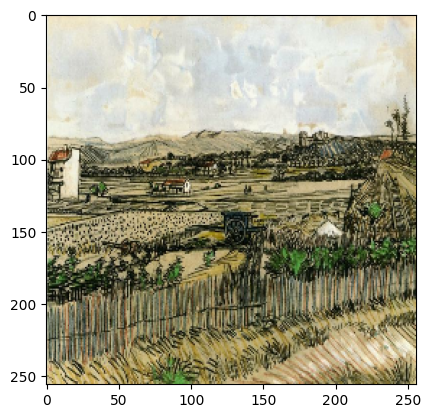

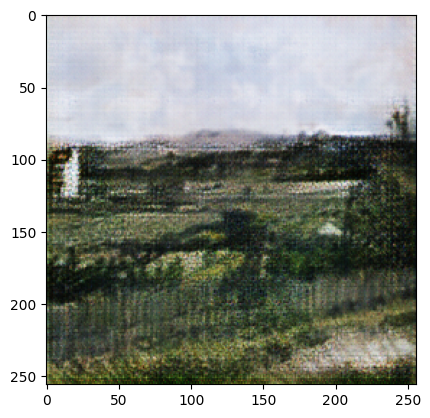

In [ ]:
#tf.keras.saving.get_custom_objects().clear()

model_g = tf.keras.models.load_model("/content/drive/MyDrive/CycleGAN_model/model/gen_g.keras",
                                    custom_objects={'CycleGAN>InstanceNormalization': InstanceNormalization})

t_data = list(test_a_ds.take(1).as_numpy_iterator())[0]

input_image = t_data * 127.5 + 127.5
input_image = tf.cast(input_image, tf.uint8)

input_data = tf.expand_dims(t_data, axis=0)
out_image = model_g(input_data, training=True)
out_image = out_image * 127.5 +127.5
out_image = tf.squeeze(out_image)
out_image = tf.cast(out_image, tf.uint8)

plt.imshow(input_image)
plt.show()
plt.imshow(out_image)
plt.show()

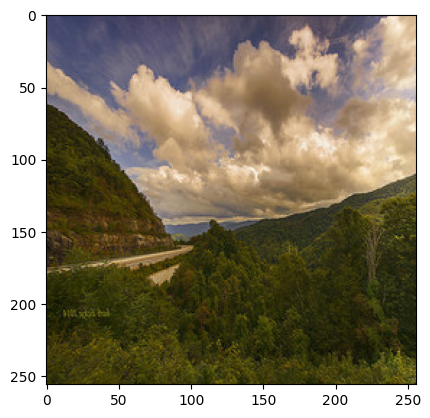

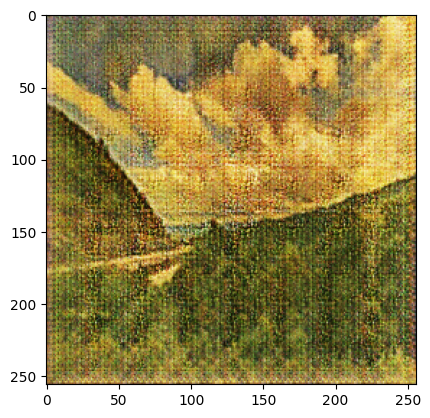

In [ ]:
#tf.keras.saving.get_custom_objects().clear()

model_f = tf.keras.models.load_model("/content/drive/MyDrive/CycleGAN_model/model/gen_f.keras",
                                    custom_objects={'CycleGAN>InstanceNormalization': InstanceNormalization})

t_data = list(test_b_ds.take(1).as_numpy_iterator())[0]

input_image = t_data * 127.5 + 127.5
input_image = tf.cast(input_image, tf.uint8)

input_data = tf.expand_dims(t_data, axis=0)
out_image = model_f(input_data, training=True)
out_image = out_image * 127.5 +127.5
out_image = tf.squeeze(out_image)
out_image = tf.cast(out_image, tf.uint8)

plt.imshow(input_image)
plt.show()
plt.imshow(out_image)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Load pre-trained models
try:
    model_g = tf.keras.models.load_model("/content/drive/MyDrive/CycleGAN_model/model/gen_g.keras",
                                        custom_objects={'InstanceNormalization': InstanceNormalization})
    model_f = tf.keras.models.load_model("/content/drive/MyDrive/CycleGAN_model/model/gen_f.keras",
                                        custom_objects={'InstanceNormalization': InstanceNormalization})

    # Assign loaded models to the CycleGAN instance
    g.generator_g = model_g
    g.generator_f = model_f

    print("Successfully loaded pre-trained models.")

except Exception as e:
    print(f"Error loading models: {e}")
    # Handle the error appropriately, e.g., initialize new models or exit
    # ...

# Continue training
g.train(train_ds,
        1,  # Number of additional epochs
        sampling_image_g_func=gen_images(test_a_ds, "gen_g_images"),
        sampling_image_f_func=gen_images(test_b_ds, "gen_f_images"))

Successfully loaded pre-trained models.
gen_f learning rate: 0.00019999999494757503
gen_g learning rate: 0.00019999999494757503


epoch:1/1 : 100%|██████████| 874/874 [31:21<00:00,  2.15s/it]


Gnerator:
┌──────────────┬──────────────┐
│   gen_g_loss │   gen_f_loss │
├──────────────┼──────────────┤
│      3.80876 │      3.97317 │
└──────────────┴──────────────┘
Discriminator:
┌───────────────┬───────────────┐
│   disc_x_loss │   disc_y_loss │
├───────────────┼───────────────┤
│      0.681527 │      0.692524 │
└───────────────┴───────────────┘
Save model


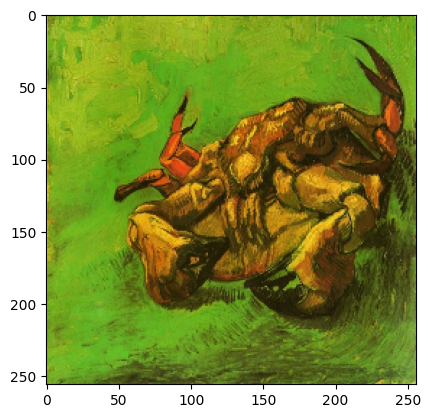

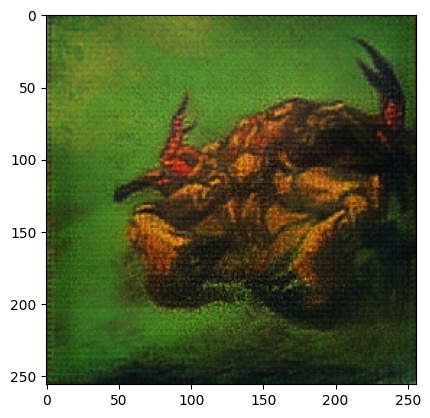

In [ ]:
#tf.keras.saving.get_custom_objects().clear()

model_g = tf.keras.models.load_model("/content/drive/MyDrive/CycleGAN_model/model/gen_g_2.keras",
                                    custom_objects={'CycleGAN>InstanceNormalization': InstanceNormalization})

t_data = list(test_a_ds.take(1).as_numpy_iterator())[0]

input_image = t_data * 127.5 + 127.5
input_image = tf.cast(input_image, tf.uint8)

input_data = tf.expand_dims(t_data, axis=0)
out_image = model_g(input_data, training=True)
out_image = out_image * 127.5 +127.5
out_image = tf.squeeze(out_image)
out_image = tf.cast(out_image, tf.uint8)

plt.imshow(input_image)
plt.show()
plt.imshow(out_image)
plt.show()

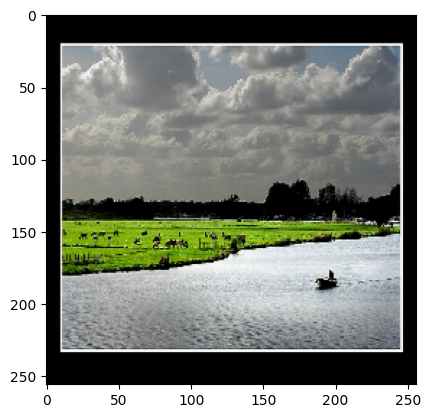

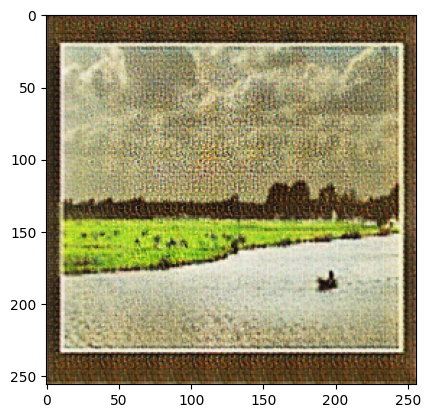

In [ ]:
#tf.keras.saving.get_custom_objects().clear()

model_f = tf.keras.models.load_model("/content/drive/MyDrive/CycleGAN_model/model/gen_f_2.keras",
                                    custom_objects={'CycleGAN>InstanceNormalization': InstanceNormalization})

t_data = list(test_b_ds.take(1).as_numpy_iterator())[0]

input_image = t_data * 127.5 + 127.5
input_image = tf.cast(input_image, tf.uint8)

input_data = tf.expand_dims(t_data, axis=0)
out_image = model_f(input_data, training=True)
out_image = out_image * 127.5 +127.5
out_image = tf.squeeze(out_image)
out_image = tf.cast(out_image, tf.uint8)

plt.imshow(input_image)
plt.show()
plt.imshow(out_image)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Load pre-trained models
try:
    model_g = tf.keras.models.load_model("/content/drive/MyDrive/CycleGAN_model/model/gen_g_2.keras",
                                        custom_objects={'InstanceNormalization': InstanceNormalization})
    model_f = tf.keras.models.load_model("/content/drive/MyDrive/CycleGAN_model/model/gen_f_2.keras",
                                        custom_objects={'InstanceNormalization': InstanceNormalization})

    # Assign loaded models to the CycleGAN instance
    g.generator_g = model_g
    g.generator_f = model_f

    print("Successfully loaded pre-trained models.")

except Exception as e:
    print(f"Error loading models: {e}")
    # Handle the error appropriately, e.g., initialize new models or exit
    # ...

# Continue training
g.train(train_ds,
        4,  # Number of additional epochs
        sampling_image_g_func=gen_images(test_a_ds, "gen_g_images"),
        sampling_image_f_func=gen_images(test_b_ds, "gen_f_images"))

Successfully loaded pre-trained models.
gen_f learning rate: 0.00019999999494757503
gen_g learning rate: 0.00019999999494757503


epoch:1/4 : 100%|██████████| 874/874 [30:21<00:00,  2.08s/it]


Gnerator:
┌──────────────┬──────────────┐
│   gen_g_loss │   gen_f_loss │
├──────────────┼──────────────┤
│      3.66849 │      3.81268 │
└──────────────┴──────────────┘
Discriminator:
┌───────────────┬───────────────┐
│   disc_x_loss │   disc_y_loss │
├───────────────┼───────────────┤
│      0.687769 │      0.693102 │
└───────────────┴───────────────┘
Save model


gen_f learning rate: 0.00019999999494757503
gen_g learning rate: 0.00019999999494757503


epoch:2/4 : 100%|██████████| 874/874 [29:10<00:00,  2.00s/it]


Gnerator:
┌──────────────┬──────────────┐
│   gen_g_loss │   gen_f_loss │
├──────────────┼──────────────┤
│      3.71779 │      3.90967 │
└──────────────┴──────────────┘
Discriminator:
┌───────────────┬───────────────┐
│   disc_x_loss │   disc_y_loss │
├───────────────┼───────────────┤
│      0.628494 │      0.670758 │
└───────────────┴───────────────┘
Save model


gen_f learning rate: 0.00019999999494757503
gen_g learning rate: 0.00019999999494757503


epoch:3/4 : 100%|██████████| 874/874 [28:55<00:00,  1.99s/it]


Gnerator:
┌──────────────┬──────────────┐
│   gen_g_loss │   gen_f_loss │
├──────────────┼──────────────┤
│      3.75454 │      3.93524 │
└──────────────┴──────────────┘
Discriminator:
┌───────────────┬───────────────┐
│   disc_x_loss │   disc_y_loss │
├───────────────┼───────────────┤
│      0.607782 │      0.655552 │
└───────────────┴───────────────┘
Save model


gen_f learning rate: 0.00019999999494757503
gen_g learning rate: 0.00019999999494757503


epoch:4/4 : 100%|██████████| 874/874 [28:58<00:00,  1.99s/it]


Gnerator:
┌──────────────┬──────────────┐
│   gen_g_loss │   gen_f_loss │
├──────────────┼──────────────┤
│      3.79436 │      3.97322 │
└──────────────┴──────────────┘
Discriminator:
┌───────────────┬───────────────┐
│   disc_x_loss │   disc_y_loss │
├───────────────┼───────────────┤
│       0.59628 │      0.650153 │
└───────────────┴───────────────┘
Save model


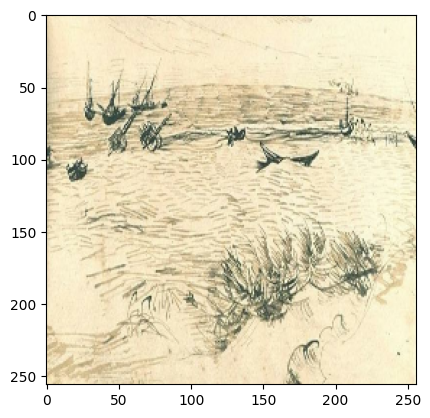

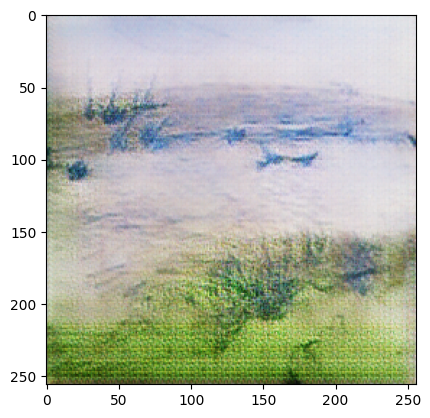

In [ ]:
#tf.keras.saving.get_custom_objects().clear()

model_g = tf.keras.models.load_model("/content/drive/MyDrive/CycleGAN_model/model/gen_g_3.keras",
                                    custom_objects={'CycleGAN>InstanceNormalization': InstanceNormalization})

t_data = list(test_a_ds.take(1).as_numpy_iterator())[0]

input_image = t_data * 127.5 + 127.5
input_image = tf.cast(input_image, tf.uint8)

input_data = tf.expand_dims(t_data, axis=0)
out_image = model_g(input_data, training=True)
out_image = out_image * 127.5 +127.5
out_image = tf.squeeze(out_image)
out_image = tf.cast(out_image, tf.uint8)

plt.imshow(input_image)
plt.show()
plt.imshow(out_image)
plt.show()

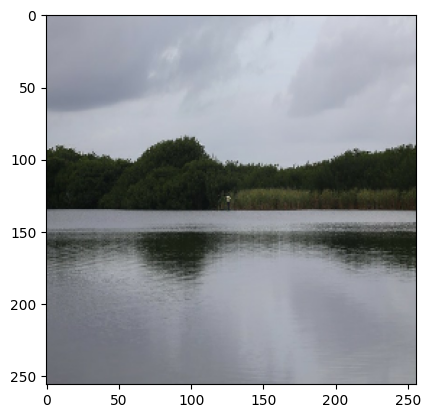

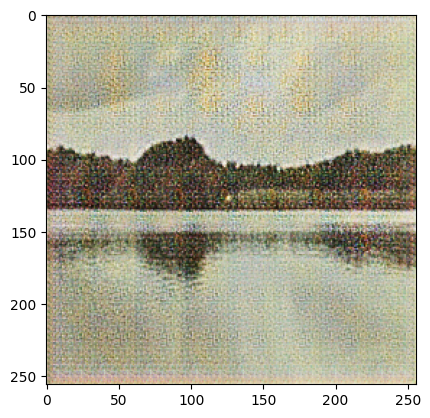

In [ ]:
#tf.keras.saving.get_custom_objects().clear()

model_f = tf.keras.models.load_model("/content/drive/MyDrive/CycleGAN_model/model/gen_f_3.keras",
                                    custom_objects={'CycleGAN>InstanceNormalization': InstanceNormalization})

t_data = list(test_b_ds.take(1).as_numpy_iterator())[0]

input_image = t_data * 127.5 + 127.5
input_image = tf.cast(input_image, tf.uint8)

input_data = tf.expand_dims(t_data, axis=0)
out_image = model_f(input_data, training=True)
out_image = out_image * 127.5 +127.5
out_image = tf.squeeze(out_image)
out_image = tf.cast(out_image, tf.uint8)

plt.imshow(input_image)
plt.show()
plt.imshow(out_image)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Load pre-trained models
try:
    model_g = tf.keras.models.load_model("/content/drive/MyDrive/CycleGAN_model/model/gen_g_3.keras",
                                        custom_objects={'InstanceNormalization': InstanceNormalization})
    model_f = tf.keras.models.load_model("/content/drive/MyDrive/CycleGAN_model/model/gen_f_3.keras",
                                        custom_objects={'InstanceNormalization': InstanceNormalization})

    # Assign loaded models to the CycleGAN instance
    g.generator_g = model_g
    g.generator_f = model_f

    print("Successfully loaded pre-trained models.")

except Exception as e:
    print(f"Error loading models: {e}")
    # Handle the error appropriately, e.g., initialize new models or exit
    # ...

# Continue training
g.train(train_ds,
        2,  # Number of additional epochs
        sampling_image_g_func=gen_images(test_a_ds, "gen_g_images"),
        sampling_image_f_func=gen_images(test_b_ds, "gen_f_images"))

Successfully loaded pre-trained models.
gen_f learning rate: 0.00019999999494757503
gen_g learning rate: 0.00019999999494757503


epoch:1/2 : 100%|██████████| 874/874 [29:44<00:00,  2.04s/it]


Gnerator:
┌──────────────┬──────────────┐
│   gen_g_loss │   gen_f_loss │
├──────────────┼──────────────┤
│      3.52302 │      3.69693 │
└──────────────┴──────────────┘
Discriminator:
┌───────────────┬───────────────┐
│   disc_x_loss │   disc_y_loss │
├───────────────┼───────────────┤
│      0.688468 │      0.699439 │
└───────────────┴───────────────┘
Save model


gen_f learning rate: 0.00019999999494757503
gen_g learning rate: 0.00019999999494757503


epoch:2/2 : 100%|██████████| 874/874 [29:23<00:00,  2.02s/it]


Gnerator:
┌──────────────┬──────────────┐
│   gen_g_loss │   gen_f_loss │
├──────────────┼──────────────┤
│      3.53508 │      3.75244 │
└──────────────┴──────────────┘
Discriminator:
┌───────────────┬───────────────┐
│   disc_x_loss │   disc_y_loss │
├───────────────┼───────────────┤
│      0.642692 │      0.682556 │
└───────────────┴───────────────┘
Save model


In [ ]:
g.train(train_ds,
        3,  # Number of additional epochs
        sampling_image_g_func=gen_images(test_a_ds, "gen_g_images"),
        sampling_image_f_func=gen_images(test_b_ds, "gen_f_images"))

gen_f learning rate: 0.00019999999494757503
gen_g learning rate: 0.00019999999494757503


epoch:1/3 : 100%|██████████| 874/874 [29:11<00:00,  2.00s/it]


Gnerator:
┌──────────────┬──────────────┐
│   gen_g_loss │   gen_f_loss │
├──────────────┼──────────────┤
│      3.59729 │       3.8324 │
└──────────────┴──────────────┘
Discriminator:
┌───────────────┬───────────────┐
│   disc_x_loss │   disc_y_loss │
├───────────────┼───────────────┤
│      0.612426 │      0.665688 │
└───────────────┴───────────────┘
Save model


gen_f learning rate: 0.00019999999494757503
gen_g learning rate: 0.00019999999494757503


epoch:2/3 : 100%|██████████| 874/874 [29:12<00:00,  2.01s/it]


Gnerator:
┌──────────────┬──────────────┐
│   gen_g_loss │   gen_f_loss │
├──────────────┼──────────────┤
│      3.68927 │      3.93741 │
└──────────────┴──────────────┘
Discriminator:
┌───────────────┬───────────────┐
│   disc_x_loss │   disc_y_loss │
├───────────────┼───────────────┤
│      0.582592 │      0.651219 │
└───────────────┴───────────────┘
Save model


gen_f learning rate: 0.00019999999494757503
gen_g learning rate: 0.00019999999494757503


epoch:3/3 : 100%|██████████| 874/874 [29:21<00:00,  2.02s/it]


Gnerator:
┌──────────────┬──────────────┐
│   gen_g_loss │   gen_f_loss │
├──────────────┼──────────────┤
│      3.73473 │      3.97482 │
└──────────────┴──────────────┘
Discriminator:
┌───────────────┬───────────────┐
│   disc_x_loss │   disc_y_loss │
├───────────────┼───────────────┤
│      0.573443 │      0.636126 │
└───────────────┴───────────────┘
Save model


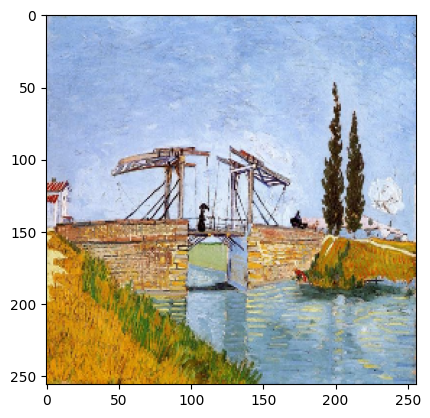

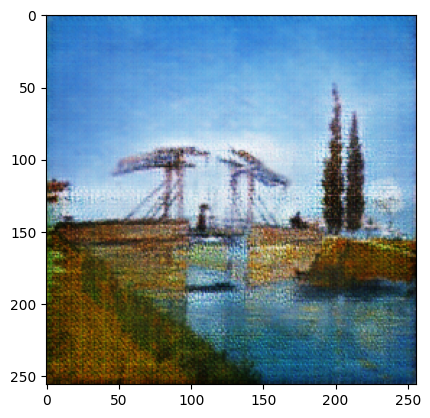

In [ ]:
#tf.keras.saving.get_custom_objects().clear()

model_g = tf.keras.models.load_model("/content/drive/MyDrive/CycleGAN_model/model/gen_g_4.keras",
                                    custom_objects={'CycleGAN>InstanceNormalization': InstanceNormalization})

t_data = list(test_a_ds.take(1).as_numpy_iterator())[0]

input_image = t_data * 127.5 + 127.5
input_image = tf.cast(input_image, tf.uint8)

input_data = tf.expand_dims(t_data, axis=0)
out_image = model_g(input_data, training=True)
out_image = out_image * 127.5 +127.5
out_image = tf.squeeze(out_image)
out_image = tf.cast(out_image, tf.uint8)

plt.imshow(input_image)
plt.show()
plt.imshow(out_image)
plt.show()

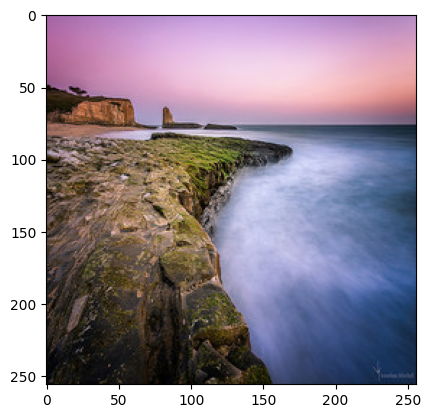

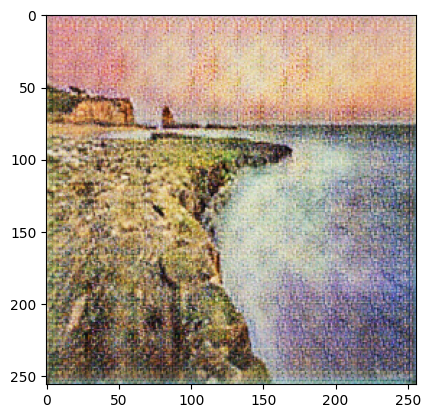

In [ ]:
#tf.keras.saving.get_custom_objects().clear()

model_f = tf.keras.models.load_model("/content/drive/MyDrive/CycleGAN_model/model/gen_f_4.keras",
                                    custom_objects={'CycleGAN>InstanceNormalization': InstanceNormalization})

t_data = list(test_b_ds.take(1).as_numpy_iterator())[0]

input_image = t_data * 127.5 + 127.5
input_image = tf.cast(input_image, tf.uint8)

input_data = tf.expand_dims(t_data, axis=0)
out_image = model_f(input_data, training=True)
out_image = out_image * 127.5 +127.5
out_image = tf.squeeze(out_image)
out_image = tf.cast(out_image, tf.uint8)

plt.imshow(input_image)
plt.show()
plt.imshow(out_image)
plt.show()

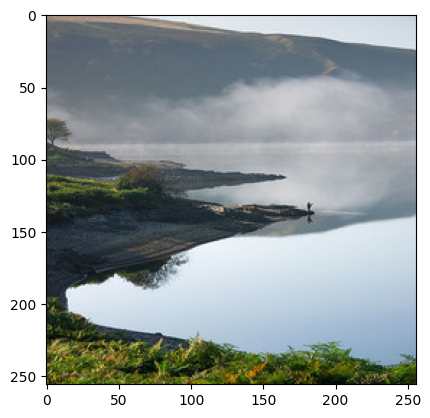

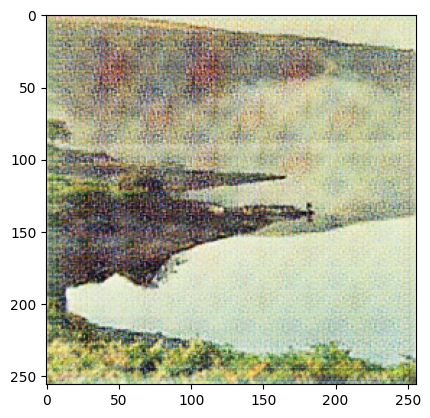

In [ ]:
model_f = tf.keras.models.load_model("/content/drive/MyDrive/CycleGAN_model/model/gen_f_4.keras",
                                    custom_objects={'CycleGAN>InstanceNormalization': InstanceNormalization})

t_data = list(test_b_ds.take(1).as_numpy_iterator())[0]

input_image = t_data * 127.5 + 127.5
input_image = tf.cast(input_image, tf.uint8)

input_data = tf.expand_dims(t_data, axis=0)
out_image = model_f(input_data, training=True)
out_image = out_image * 127.5 +127.5
out_image = tf.squeeze(out_image)
out_image = tf.cast(out_image, tf.uint8)

plt.imshow(input_image)
plt.show()
plt.imshow(out_image)
plt.show()

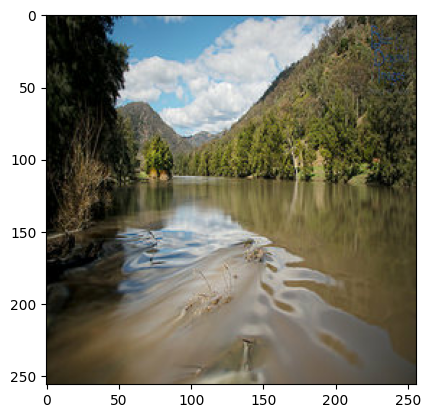

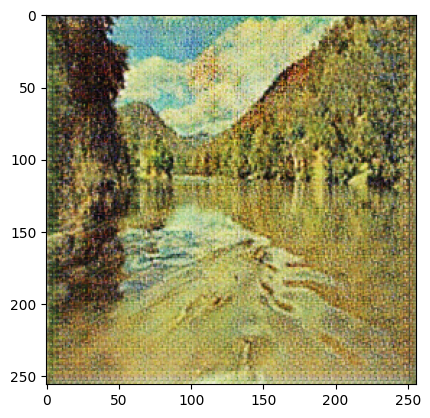

In [ ]:
model_f = tf.keras.models.load_model("/content/drive/MyDrive/CycleGAN_model/model/gen_f_4.keras",
                                    custom_objects={'CycleGAN>InstanceNormalization': InstanceNormalization})

t_data = list(test_b_ds.take(1).as_numpy_iterator())[0]

input_image = t_data * 127.5 + 127.5
input_image = tf.cast(input_image, tf.uint8)

input_data = tf.expand_dims(t_data, axis=0)
out_image = model_f(input_data, training=True)
out_image = out_image * 127.5 +127.5
out_image = tf.squeeze(out_image)
out_image = tf.cast(out_image, tf.uint8)

plt.imshow(input_image)
plt.show()
plt.imshow(out_image)
plt.show()

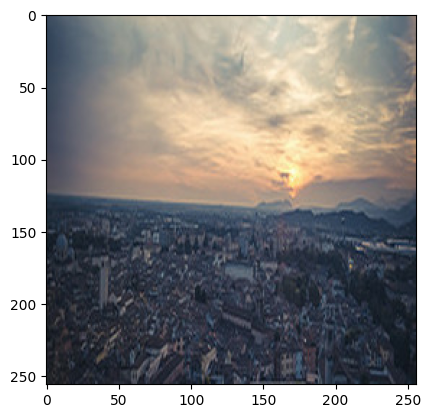

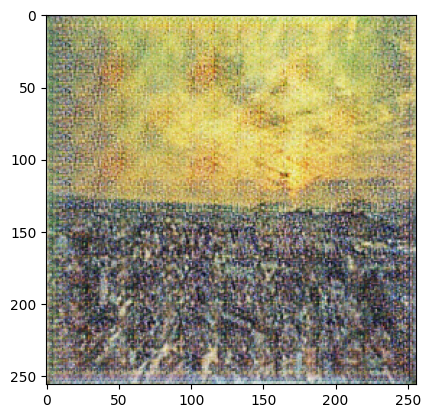

In [ ]:
model_f = tf.keras.models.load_model("/content/drive/MyDrive/CycleGAN_model/model/gen_f_4.keras",
                                    custom_objects={'CycleGAN>InstanceNormalization': InstanceNormalization})

t_data = list(test_b_ds.take(1).as_numpy_iterator())[0]

input_image = t_data * 127.5 + 127.5
input_image = tf.cast(input_image, tf.uint8)

input_data = tf.expand_dims(t_data, axis=0)
out_image = model_f(input_data, training=True)
out_image = out_image * 127.5 +127.5
out_image = tf.squeeze(out_image)
out_image = tf.cast(out_image, tf.uint8)

plt.imshow(input_image)
plt.show()
plt.imshow(out_image)
plt.show()

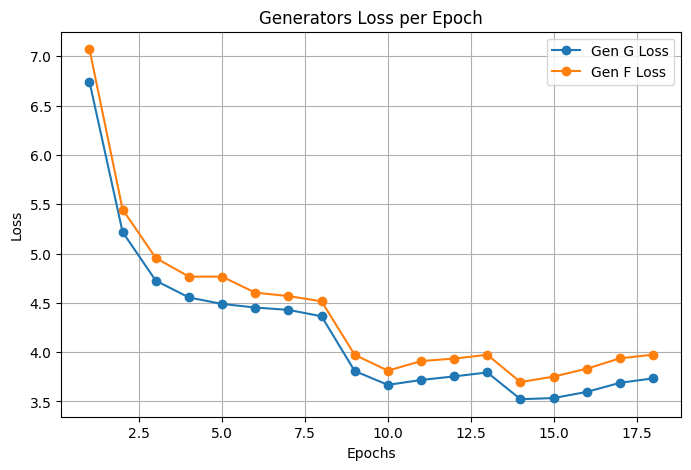

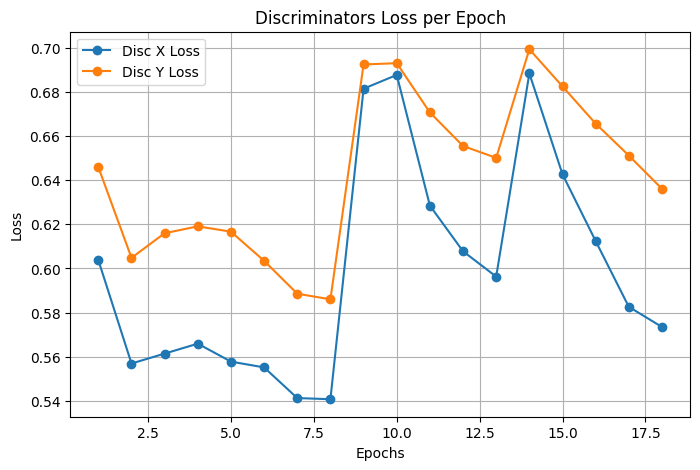

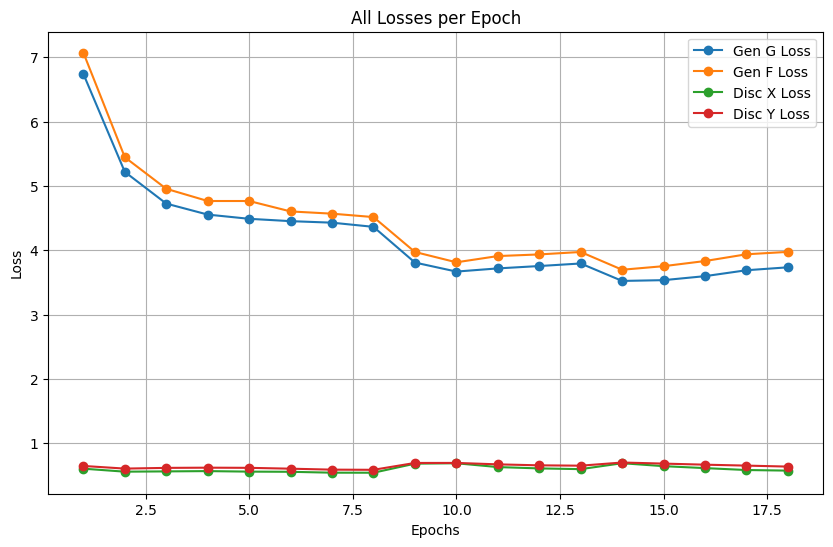

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 19))  # Có 18 epoch

gen_g_loss = [6.74188, 5.21823, 4.72539, 4.55463, 4.48902, 4.45259, 4.42892, 4.36391,
              3.80876, 3.66849, 3.71779, 3.75454, 3.79436, 3.52302, 3.53508, 3.59729,
              3.68927, 3.73473]
gen_f_loss = [7.07159, 5.44618, 4.9554, 4.76575, 4.76575, 4.60364, 4.56891, 4.51593,
              3.97317, 3.81268, 3.90967, 3.93524, 3.97322, 3.69693, 3.75244, 3.8324,
              3.93741, 3.97482]

disc_x_loss = [0.603791, 0.556876, 0.56138, 0.565874, 0.557733, 0.555113, 0.541201,
               0.540677, 0.681527, 0.687769, 0.628494, 0.607782, 0.59628, 0.688468,
               0.642692, 0.612426, 0.582592, 0.573443]
disc_y_loss = [0.64596, 0.604808, 0.615977, 0.619085, 0.616674, 0.603455, 0.588541,
               0.58598, 0.692524, 0.693102, 0.670758, 0.655552, 0.650153, 0.699439,
               0.682556, 0.665688, 0.651219, 0.636126]

# Đồ thị chung cho Generators
plt.figure(figsize=(8, 5))
plt.plot(epochs, gen_g_loss, label='Gen G Loss', marker='o')
plt.plot(epochs, gen_f_loss, label='Gen F Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generators Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Đồ thị chung cho Discriminators
plt.figure(figsize=(8, 5))
plt.plot(epochs, disc_x_loss, label='Disc X Loss', marker='o')
plt.plot(epochs, disc_y_loss, label='Disc Y Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Discriminators Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Đồ thị chung cả 4 giá trị
plt.figure(figsize=(10, 6))
plt.plot(epochs, gen_g_loss, label='Gen G Loss', marker='o')
plt.plot(epochs, gen_f_loss, label='Gen F Loss', marker='o')
plt.plot(epochs, disc_x_loss, label='Disc X Loss', marker='o')
plt.plot(epochs, disc_y_loss, label='Disc Y Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('All Losses per Epoch')
plt.legend()
plt.grid(True)
plt.show()
